P6 FONG

# Analysez les ventes d'une librairie avec R ou Python

* [Partie 1 - Analyse des différents indicateurs de vente](#P1)
     * [1.1 Indicateurs et graphiques autour du chiffre d'affaires, avec notamment l’évolution dans le temps](#P11)
     * [1.2 Zoom sur les références, pour voir un peu les tops et les flops, la répartition par catégorie, etc.](#P12)
     * [1.3 Informations sur les profils des clients, et également la répartition du chiffre d'affaires entre eux, via par exemple une courbe de Lorenz](#P13)


* [Partie 2 - Analyse ciblée sur les clients](#P2)
     * [2.1 Lien entre le genre d’un client et les catégories des livres achetés](#P21)
     * [2.2 Lien entre l’âge des clients et le montant total des achats, la fréquence d’achat, la taille du panier moyen et les catégories des livres achetés](#P22)
     * [2.3 Calculer la probabilité qu’un client achète la référence 0_525 sachant qu’il a acheté la référence 2_159](#P23)

In [1]:
##############################################################
# Librairies

import pandas as pd
import numpy as np
import hvplot.pandas
from datetime import datetime as dt
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')

##############################################################
# Importations des jeux de données

customers = pd.read_csv('customers.csv')
products = pd.read_csv('products.csv')
transactions = pd.read_csv('transactions.csv')

##############################################################
# Vérification des données

customers.info()
products.info()
transactions.info()
# note : pas de valeur nulle

##############################################################
# Vérification des doublons

transactions[transactions.duplicated()]
# lignes de tests à supprimer après merge, afin de supprimer le client_id et le id_prod test aussi

##############################################################
# Création base de travail

df = pd.merge(transactions, customers, on='client_id', how='outer')
df = pd.merge(df, products, on='id_prod', how='outer')

##############################################################
# Vérification des valeurs nulles
df[df.isna().any(axis=1)]

##############################################################
# Supprimer les lignes tests     

df = df[df['id_prod']!='T_0']

##############################################################
# Nettoyage de la base

df[['date', 'date_code']] = df['date'].str.split('.', expand=True)

##############################################################
# Convertir les données 

df['date'] = pd.to_datetime(df['date'])#.dt.date
df['birth'] = df['birth'].fillna(0).astype(int)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8623 non-null   object
 1   sex        8623 non-null   object
 2   birth      8623 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3287 non-null   object 
 1   price    3287 non-null   float64
 2   categ    3287 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679532 entries, 0 to 679531
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     679532 non-null  object
 1   date        679532 non-null  object
 2   session_i

## Partie 1 - Analyse des différents indicateurs de vente <a class="anchor" id="P1"></a>

### 1.1 Indicateurs et graphiques autour du chiffre d'affaires, avec notamment l’évolution dans le temps<a class="anchor" id="P11"></a>

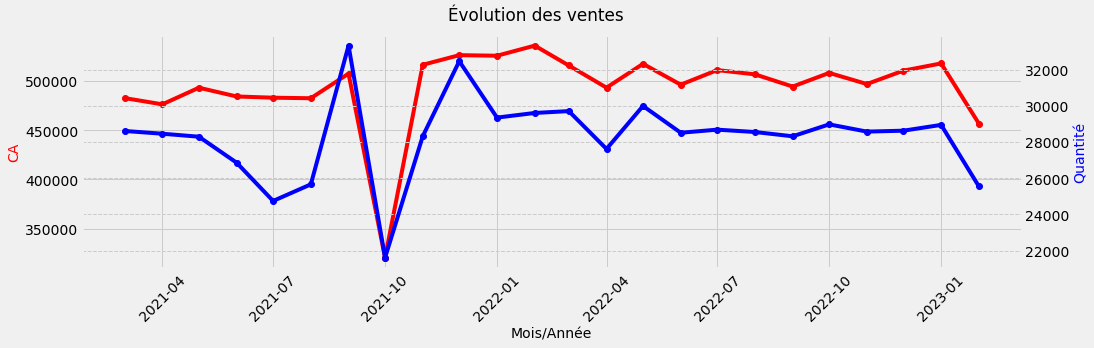

In [2]:
##############################################################
# Évolution du chiffre d'affaire par mois

ca = df[~df['date'].isnull()].reset_index(drop=True)
ca['YM'] = ca['date'].dt.to_period('M').dt.to_timestamp()
ca_grp_mois = ca.groupby('YM').sum('price').reset_index()
vt_grp_mois = ca.groupby('YM')['session_id'].count().reset_index()

x = np.array(ca_grp_mois['YM'])
y = np.array(ca_grp_mois['price'])
y2 = np.array(vt_grp_mois['session_id'])

fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(x, y, color="red", marker="o")
ax.set_xlabel("Mois/Année",fontsize=14)
ax.set_ylabel("CA",color="red",fontsize=14)
ax2 = ax.twinx()
ax2.plot(x, y2,color="blue",marker="o")
ax2.set_ylabel("Quantité",color="blue",fontsize=14)

plt.setp(ax.get_xticklabels(), rotation=45)
fig.suptitle("Évolution des ventes") 
plt.grid(True, which="both", linestyle='--')
plt.show()

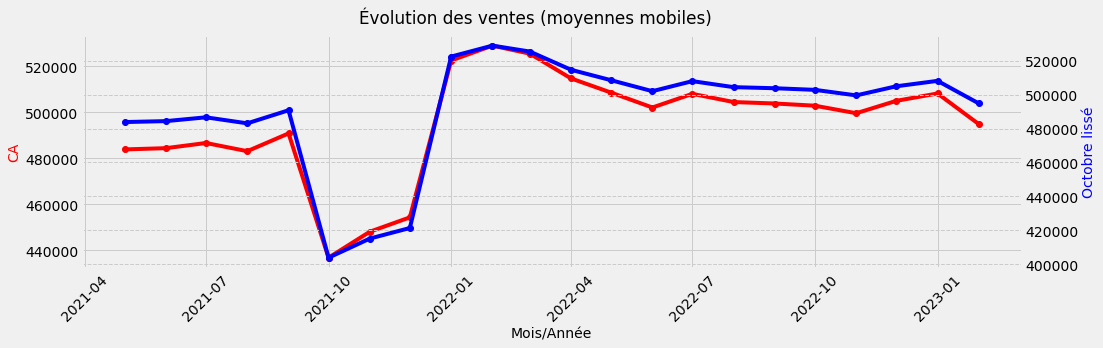

In [3]:
##############################################################
# Moyennes mobiles afin de lisser les valeurs dans le temps

ca_grp_mois['moy_mobile'] = ca_grp_mois['price'].rolling(window=3).mean()
x = np.array(ca_grp_mois['YM'])
y = np.array(ca_grp_mois['moy_mobile'])

ca_grp_mois_2 = ca_grp_mois.copy()
ca_grp_mois_2.loc[7, 'price'] = (190613.78+252910.39)/2 # moyenne du mois précédent et suivant
ca_grp_mois_2['moy_mobile'] = ca_grp_mois_2['price'].rolling(window=3).mean()
y2 = np.array(ca_grp_mois_2['moy_mobile'])

fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(x, y, color="red", marker="o")
ax.set_xlabel("Mois/Année",fontsize=14)
ax.set_ylabel("CA",color="red",fontsize=14)
ax2 = ax.twinx()
ax2.plot(x, y2,color="blue",marker="o")
ax2.set_ylabel("Octobre lissé",color="blue",fontsize=14)

plt.setp(ax.get_xticklabels(), rotation=45)
fig.suptitle("Évolution des ventes (moyennes mobiles)") 
plt.grid(True, which="both", linestyle='--')
plt.show()

Il y a une chute du CA sur Octobre 2010.
Nous allons procéder à plusieurs vérification afin de comprendre d'où cette baisse peut provenir:
- si le CA est complet sur Octobre
- les prix
- si cela est lié à une catégorie de produit en particulier

In [4]:
##############################################################
# Vérification si CA complet sur Octobre 2021 (effectuée également sur 02/23 et 10/21)

ca[(ca['YM'].dt.year == 2021) & (ca['YM'].dt.month == 10)]['date'].sort_values().dt.day.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
      dtype=int64)

Il y a bien eu un CA sur tous les jours du mois d'Octobre 2021

In [5]:
##############################################################
# Vérification des différents prix sur Octobre 2021

import sys
np.set_printoptions(threshold=sys.maxsize)
ca[(ca['YM'].dt.year == 2021) & (ca['YM'].dt.month == 10)]['price'].unique()
# Cette ligne fait remonter qu'il y a des NaN à creuser

ca[(ca['YM'].dt.year == 2021) & (ca['YM'].dt.month == 10) & (ca['price'].isna())]

id_prod                date session_id client_id sex  birth  price  \
311755  0_2245 2021-10-04 21:20:27   s_100047    c_8138   f   1984    NaN   
311773  0_2245 2021-10-20 13:11:05   s_107564    c_1746   m   1994    NaN   
311787  0_2245 2021-10-19 00:28:01   s_106841    c_3953   f   1984    NaN   
311818  0_2245 2021-10-04 13:36:19    s_99885    c_1514   f   1982    NaN   
311819  0_2245 2021-10-26 03:31:42   s_110231    c_8286   f   1980    NaN   
311955  0_2245 2021-10-15 09:31:31   s_105069    c_4188   f   1935    NaN   
311963  0_2245 2021-10-19 09:32:03   s_107022    c_6128   m   1986    NaN   

        categ date_code         YM  
311755    NaN    540982 2021-10-01  
311773    NaN    671456 2021-10-01  
311787    NaN    920054 2021-10-01  
311818    NaN    612226 2021-10-01  
311819    NaN    296144 2021-10-01  
311955    NaN    539354 2021-10-01  
311963    NaN    667461 2021-10-01

Il y a une référence 0_2245 sans prix et sans catégorie

In [6]:
##############################################################
# Visualisation de la notation des références par catégories

ca.groupby(['categ'])['id_prod'].unique()

categ
0.0    [0_1518, 0_1627, 0_1104, 0_1390, 0_1547, 0_115...
1.0    [1_379, 1_464, 1_457, 1_738, 1_201, 1_253, 1_3...
2.0    [2_101, 2_200, 2_62, 2_226, 2_110, 2_1, 2_173,...
Name: id_prod, dtype: object

Les références commencent par le numéro de la catégorie dans lesquelles elles se trouvent.
Exemple: 0_1518, commence par 0 appartient à la catégorie 0

In [7]:
##############################################################
# Affecter un prix ainsi qu'une catégorie pour les données manquantes à la référence 0_2245
# Basé sur la construction des références dans chaque catégorie, on suppose que 0_2245 appartient à la catégorie 0
# Remplacer le prix par le prix median de la catégorie

simul = ca.copy()
simul['categ'].fillna(0., inplace=True)
simul['price'].fillna(9.99, inplace=True)
simul.info()

##############################################################
# Prix médian par catégories

# ca.groupby(['categ'])['price'].median()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679332 entries, 0 to 679331
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     679332 non-null  object        
 1   date        679332 non-null  datetime64[ns]
 2   session_id  679332 non-null  object        
 3   client_id   679332 non-null  object        
 4   sex         679332 non-null  object        
 5   birth       679332 non-null  int32         
 6   price       679332 non-null  float64       
 7   categ       679332 non-null  float64       
 8   date_code   679332 non-null  object        
 9   YM          679332 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int32(1), object(5)
memory usage: 49.2+ MB


In [8]:
##############################################################
# Vérifier si les données manquantes expliquent la baisse du CA

print(ca[(ca['YM'].dt.year == 2021) & (ca['YM'].dt.month == 10)]['price'].sum())
print(simul[(simul['YM'].dt.year == 2021) & (simul['YM'].dt.month == 10)]['price'].sum())

320798.74
320868.67000000004


L'imputation des données manquantes a un impact peu significatif sur le CA (environ 100€ d'écart)

In [9]:
##############################################################
# Vérifier s'il n'y a pas plusieurs prix pour une référence

ca['id_prod'].nunique() # 3266 références uniques

t = ca.copy()
t = t.loc[:, ['id_prod', 'price']]
t.drop_duplicates(inplace = True)
print(t) # 3266 après suppression des doublons

       id_prod   price
0       0_1518    4.18
674     0_1627    3.99
1364    0_1104   13.21
1916    0_1390   19.37
2796    0_1547    8.99
...        ...     ...
679322    0_69   25.99
679326  0_1633   24.99
679327   1_408   35.24
679330    2_81   86.99
679331    2_98  149.74

[3266 rows x 2 columns]


Il n'y a pas dans de référence qui comporte plusieurs prix, donc pas d'augmentation ou de baisse de prix au cours du temps

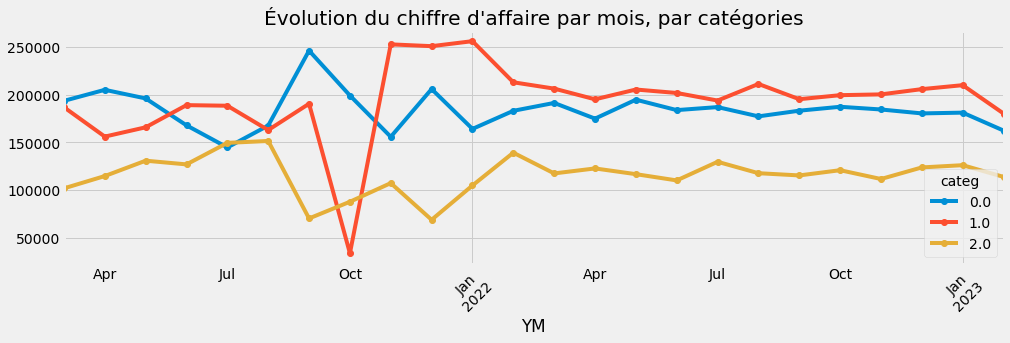

In [10]:
##############################################################
# Évolution du chiffre d'affaire par mois, par catégories

ca_grp_cat = ca.groupby(['YM','categ'])['price'].sum() 

ca_grp_cat.unstack().plot(figsize=(15, 4), marker="o")
plt.xticks(rotation=45)
plt.title("Évolution du chiffre d'affaire par mois, par catégories")
plt.show()

La baisse du CA semble être lié à la baisse du CA de la catégorie 1

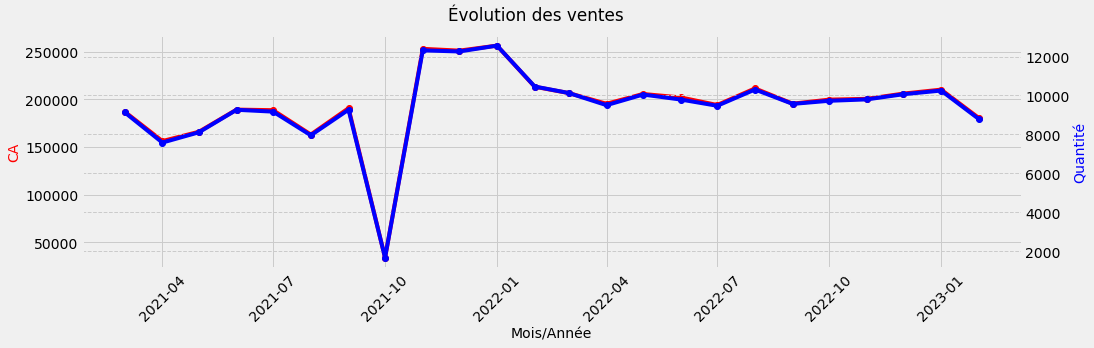

In [11]:
##############################################################
# Évolution du chiffre d'affaire sur la catégorie 1 par mois

ca_grp_mois = ca[ca['categ'] == 1].groupby('YM').sum('price').reset_index()
vt_grp_mois = ca[ca['categ'] == 1].groupby('YM')['session_id'].count().reset_index()

x = np.array(ca_grp_mois['YM'])
y = np.array(ca_grp_mois['price'])
y2 = np.array(vt_grp_mois['session_id'])

fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(x, y, color="red", marker="o")
ax.set_xlabel("Mois/Année",fontsize=14)
ax.set_ylabel("CA",color="red",fontsize=14)
ax2 = ax.twinx()
ax2.plot(x, y2,color="blue",marker="o")
ax2.set_ylabel("Quantité",color="blue",fontsize=14)

plt.setp(ax.get_xticklabels(), rotation=45)
fig.suptitle("Évolution des ventes") 
plt.grid(True, which="both", linestyle='--')
plt.show()

In [12]:
##############################################################
# CA de la catégorie 1 en Octobre 2021

ca[(ca['categ'] == 1) & (ca['YM'].dt.year == 2021) & (ca['YM'].dt.month == 10)]['price'].sum()

33762.32

In [13]:
##############################################################
# Vérification s'il y a des prix aberrants dans les catégories

ca.hvplot.box('price', by='categ')

:BoxWhisker   [categ]   (price)

In [14]:
##############################################################
# Vérifier les chiffres pour Octobre 2021
# Focus sur la quantité vendue des top références

cat1 = ca[(ca['categ'] == 1) & (ca['YM'].dt.year == 2021) & (ca['YM'].dt.month == 10)]\
.groupby(['id_prod'])\
.agg({'price': ['sum', 'min', 'count']})\
.reset_index()
cat1.columns = ['_'.join(col) for col in cat1]
cat1.sort_values(by='price_count', ascending=False).head(10)

id_prod_  price_sum  price_min  price_count
159    1_432     532.40      24.20           22
124    1_367     307.78      13.99           22
143    1_396     390.60      18.60           21
181    1_462     299.88      16.66           18
129    1_376     314.82      17.49           18
174    1_451     356.83      20.99           17
144    1_397     303.84      18.99           16
145    1_398     162.72      10.17           16
179    1_459     255.84      15.99           16
155    1_417     335.84      20.99           16

In [15]:
##############################################################
# Vérifier les chiffres pour Novembre 2021
# Focus sur la quantité vendue des top références

cat1 = ca[(ca['categ'] == 1) & (ca['YM'].dt.year == 2021) & (ca['YM'].dt.month == 11)]\
.groupby(['id_prod'])\
.agg({'price': ['sum', 'min', 'count']})\
.reset_index()
cat1.columns = ['_'.join(col) for col in cat1]
cat1.sort_values(by='price_count', ascending=False).head(10)

# Vérification également effectuer sur d'autres mois mais non affiché

id_prod_  price_sum  price_min  price_count
284    1_412    2181.15      16.65          131
271    1_395    3594.76      28.99          124
355    1_498    2874.51      23.37          123
293    1_425    2004.82      16.99          118
266    1_388    1953.90      16.70          117
248    1_369    2782.84      23.99          116
272    1_396    2139.00      18.60          115
287    1_417    2371.87      20.99          113
281    1_407    1806.87      15.99          113
285    1_413    1996.89      17.99          111

Pour un mois en général, les meilleures références s'écoulent à une centaine de pièces. Or, on remarque qu'en octobre la meilleure vente en quantité est seulement à 22. Il semblerait qu'il y ait eu une erreur technique sur ce mois-ci, il serait souhaitable de corriger ce problème dès que possible.
En en attendant cette correction, j'excluerai le mois d'octobre 2021 afin d'éviter de biaiser la suite des analyses, et j'imputerais le prix manquant en prenant le prix médian de la catégorie.

In [16]:
##############################################################
# DataFrame sans le CA d'ocobre 2021

ca = ca[ca['YM'] != '2021-10-01'].reset_index(drop=True)

##############################################################
# Imputation du prix médian de la catégorie 0 pour le prix manquant de la référence 0_2245

ca['categ'] = np.where((ca.id_prod == '0_2245'), 0, ca.categ)
cat_0_mediane = ca[ca['categ'] == 0]['price'].median()
ca['price'] = np.where((ca.id_prod == '0_2245'), cat_0_mediane, ca.price)

In [17]:
##############################################################
# Répartition du chiffre d'affaire par jour de la semaine

ca['semaine'] = ca['date'].dt.day_name()
ca_grp_sem = ca.groupby('semaine').sum('price').reset_index()

# Changer l'ordre des semaines
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ca_grp_sem = ca_grp_sem.set_index('semaine').reindex(cats).reset_index()

ca_grp_sem.hvplot.bar(x='semaine',
                      y='price',
                      yformatter='%.0f',
                      ylabel="Chiffre d'Affaire",
                      xlabel='Période groupée par semaine',
                      ylim=(1600000, 1700000))

:Bars   [semaine]   (price)

On note que le week-end génère moins de CA que la semaine.
Il serait intéressant de pouvoir le comparer aux CA précédents lorsque la boutique était en physique afin de voir si la clientèle a évolué ou pas.

### 1.2 Zoom sur les références, pour voir un peu les tops et les flops, la répartition par catégorie, etc. <a class="anchor" id="P12"></a>

In [18]:
##############################################################
# Top 20 des ventes (en valeur)

top = (ca.groupby(['id_prod'])
       .agg({'price': ['sum', 'mean' ],
             'session_id':'count',
             'date': lambda x: x.max() - x.min(),
             'categ': 'mean'})
       .reset_index())
top.columns = ['_'.join(col) for col in top.columns]
top = top.rename(columns={'id_prod_': 'Réf. produit',
                        'price_sum': 'CA par produit',
                        'price_mean': 'Prix moyen',
                        'session_id_count': 'Qté vendue',
                        'date_<lambda>': 'Temps écoulé entre la 1ère vente et la dernière',
                        'categ_mean': 'Catégorie'})
top.sort_values(by='CA par produit', ascending=False).head(20)

Réf. produit  CA par produit  Prix moyen  Qté vendue  \
3095        2_159        92265.68      145.99         632   
3069        2_135        67403.23       68.99         977   
3044        2_112        62840.10       67.57         930   
3033        2_102        58962.58       59.14         997   
3151        2_209        55362.09       69.99         791   
2618        1_395        53950.39       28.99        1861   
2590        1_369        53665.63       23.99        2237   
3042        2_110        51916.50       62.25         834   
2640        1_414        51615.78       23.83        2166   
3200         2_39        51147.18       57.99         882   
2606        1_383        51080.38       28.99        1762   
3103        2_166        51068.88      230.04         222   
2732        1_498        49474.29       23.37        2117   
3205         2_43        48363.09       69.99         691   
2631        1_406        47908.11       24.81        1931   
2587        1_366        46691.44       28.54        1636   
2608        1_385        46496.11       25.99        1789   
2659        1_431        46323.45       27.99        1655   
2600        1_378        45875.64       26.61        1724   
2601        1_379        45829.02       26.99        1698   

     Temps écoulé entre la 1ère vente et la dernière  Catégorie  
3095                               728 days 03:17:07        2.0  
3069                               728 days 18:48:31        2.0  
3044                               727 days 07:40:35        2.0  
3033                               729 days 18:10:33        2.0  
3151                               726 days 09:16:26        2.0  
2618                               727 days 18:30:18        1.0  
2590                               728 days 21:48:53        1.0  
3042                               728 days 05:28:08        2.0  
2640                               729 days 13:03:48        1.0  
3200                               729 days 05:31:20        2.0  
2606                               729 days 02:49:13        1.0  
3103                               725 days 02:48:48        2.0  
2732                               728 days 15:58:10        1.0  
3205                               729 days 02:22:03        2.0  
2631                               729 days 07:12:06        1.0  
2587                               729 days 09:08:47        1.0  
2608                               728 days 13:42:26        1.0  
2659                               728 days 20:44:56        1.0  
2600                               729 days 14:25:44        1.0  
2601                               729 days 07:02:04        1.0

In [19]:
##############################################################
# Top 20 des ventes (en quantité)

ca.groupby(['id_prod']).size().sort_values(ascending=False).head(20)

id_prod
1_369    2237
1_417    2173
1_414    2166
1_498    2117
1_425    2084
1_403    1950
1_412    1938
1_413    1931
1_406    1931
1_407    1923
1_398    1901
1_396    1900
1_395    1861
1_400    1828
1_392    1811
1_376    1791
1_385    1789
1_397    1783
1_388    1780
1_381    1767
dtype: int64

In [20]:
##############################################################
# Flop 20 des ventes (en valeur)

ca.groupby(['id_prod'])['price'].sum().sort_values().head(20)

id_prod
0_1539    0.99
0_898     1.27
0_1284    1.38
0_643     1.98
0_1653    1.98
0_807     1.99
0_541     1.99
0_1601    1.99
0_1728    2.27
0_324     2.36
0_1498    2.48
0_1840    2.56
0_1191    2.97
0_1759    2.97
0_833     2.99
0_1683    2.99
0_549     2.99
0_1151    2.99
0_1595    2.99
0_1726    3.14
Name: price, dtype: float64

In [21]:
##############################################################
# Flop 20 des ventes (en quantité)

ca.groupby(['id_prod']).size().sort_values().head(20)

id_prod
0_980     1
2_23      1
0_1533    1
0_1284    1
0_886     1
2_81      1
0_549     1
0_541     1
0_1601    1
0_1683    1
0_1595    1
0_1633    1
0_898     1
0_1728    1
0_1151    1
0_1539    1
0_833     1
2_98      1
0_1498    1
0_807     1
dtype: int64

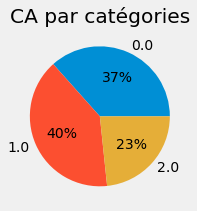

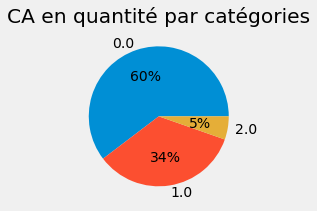

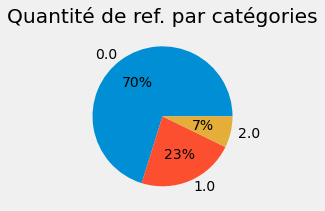

In [22]:
##############################################################
# Répartition CA par catégories

ca.groupby(['categ'])\
.agg({'price': "sum"})[['price']]\
.apply(lambda x: 100*x/x.sum())\
.plot.pie(legend=False, subplots=True, figsize=(8, 3), autopct='%1.0f%%');
plt.ylabel('')
plt.title('CA par catégories');

##############################################################
# Répartition CA en quantité par catégories

ca.groupby(['categ'])\
.agg({'id_prod': "count"})[['id_prod']]\
.apply(lambda x: 100*x/x.sum())\
.plot.pie(legend=False, subplots=True, figsize=(8, 3), autopct='%1.0f%%');
plt.ylabel('')
plt.title('CA en quantité par catégories');

##############################################################
# Répartition du nombre de références par catégories

ca.groupby(['categ'])\
.agg({'id_prod': "nunique"})[['id_prod']]\
.apply(lambda x: 100*x/x.sum())\
.plot.pie(legend=False, subplots=True, figsize=(8, 3), autopct='%1.0f%%');
plt.ylabel('')
plt.title('Quantité de ref. par catégories');


In [23]:
##############################################################
# Prix moyen par catégories

print(ca.groupby(['categ'])['price'].mean())

ca.hvplot.box('price', by='categ')

categ
0.0    10.638702
1.0    20.487357
2.0    76.248568
Name: price, dtype: float64


:BoxWhisker   [categ]   (price)

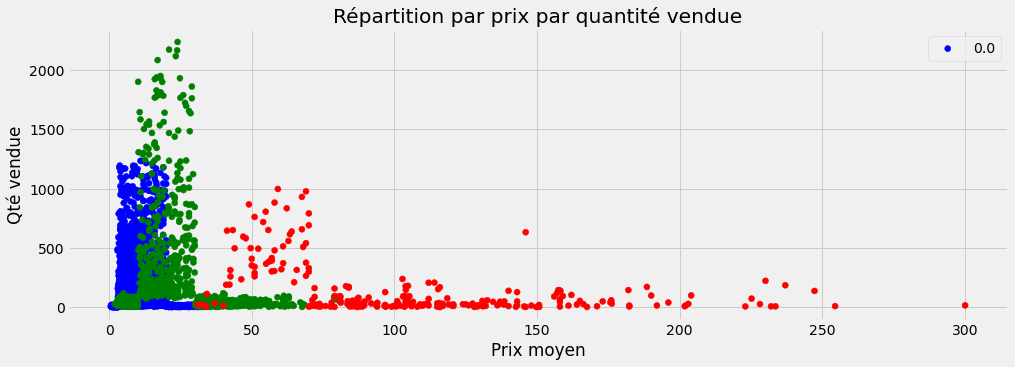

In [24]:
##############################################################
# Répartition par prix par quantité vendue

plt.figure(figsize=(15,5))
colors = {0: 'blue', 1: 'green', 2: 'red'}
plt.scatter(top['Prix moyen'], top['Qté vendue'], c=top['Catégorie'].map(colors))

plt.xlabel('Prix moyen')
plt.ylabel('Qté vendue')

plt.title("Répartition par prix par quantité vendue")
plt.legend(top['Catégorie']);

In [25]:
##############################################################
# Liste des références dont le prix est supérieur à 100€

list(ca[ca['price'] > 100]['id_prod'].unique())

['2_200',
 '2_173',
 '2_166',
 '2_0',
 '2_159',
 '2_144',
 '2_162',
 '2_123',
 '2_57',
 '2_158',
 '2_111',
 '2_136',
 '2_142',
 '2_119',
 '2_213',
 '2_194',
 '2_217',
 '2_223',
 '2_145',
 '2_151',
 '2_169',
 '2_178',
 '2_167',
 '2_228',
 '2_105',
 '2_126',
 '2_56',
 '2_156',
 '2_146',
 '2_231',
 '2_161',
 '2_199',
 '2_63',
 '2_157',
 '2_212',
 '2_222',
 '2_225',
 '2_147',
 '2_70',
 '2_2',
 '2_74',
 '2_59',
 '2_203',
 '2_195',
 '2_168',
 '2_11',
 '2_153',
 '2_106',
 '2_4',
 '2_170',
 '2_233',
 '2_17',
 '2_172',
 '2_141',
 '2_132',
 '2_66',
 '2_25',
 '2_211',
 '2_89',
 '2_220',
 '2_29',
 '2_130',
 '2_36',
 '2_205',
 '2_210',
 '2_232',
 '2_133',
 '2_42',
 '2_189',
 '2_176',
 '2_150',
 '2_187',
 '2_40',
 '2_192',
 '2_236',
 '2_15',
 '2_97',
 '2_193',
 '2_182',
 '2_94',
 '2_235',
 '2_21',
 '2_64',
 '2_121',
 '2_3',
 '2_190',
 '2_60',
 '2_196',
 '2_55',
 '2_35',
 '2_5',
 '2_103',
 '2_131',
 '2_22',
 '2_125',
 '2_31',
 '2_198',
 '2_50',
 '2_14',
 '2_90',
 '2_6',
 '2_69',
 '2_52',
 '2_117',
 '

Selon le top des ventes (en valeur), la catégorie 2 semble être en tête. On note toutefois que ce sont des produits dont le prix moyen est plutôt élevé. On suppose donc que cela correspond à une gamme plus prestigieuse de livres. Ce qui explique que ce sont des produits de cette catégorie qui remontent dans le top produits en valeur mais dans l'ensemble génère moins de CA que les autres catégorie (23%).\
Les produits de catégorie 1 sont les plus appréciés (top en quantité) et génèrent 40% du CA.\
Quant à la catégorie 0, beaucoup de références apparaissent dans le top flop et on note que cette catégorie représente 70% des références présentent sur le site, on peut donc préconiser une réduction du nombre de références au profit des autres catégories.

### 1.3 Informations sur les profils des clients, et également la répartition du chiffre d'affaires entre eux, via par exemple une courbe de Lorenz <a class="anchor" id="P12"></a>

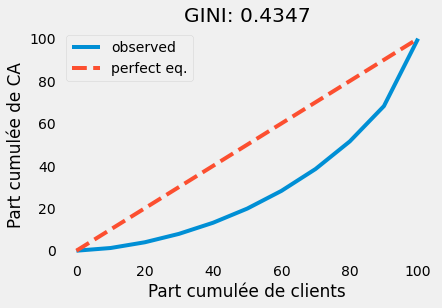

In [26]:
##############################################################
# Courbe de Lorenz - CA par client
# Utilisation de la fonction trouvée sur https://askcodez.com/calcul-du-coefficient-de-gini-en-python-numpy.html

arr = ca.groupby('client_id').agg({'price': "sum"})[['price']].sort_values(by='price')
arr = np.array(arr)

def G(v):
    bins = np.linspace(0., 100., 11)
    total = float(np.sum(v))
    yvals = []
    for b in bins:
        bin_vals = v[v <= np.percentile(v, b)]
        bin_fraction = (np.sum(bin_vals) / total) * 100.0
        yvals.append(bin_fraction)
    # perfect equality area
    pe_area = np.trapz(bins, x=bins)
    # lorenz area
    lorenz_area = np.trapz(yvals, x=bins)
    gini_val = (pe_area - lorenz_area) / float(pe_area)
    return bins, yvals, gini_val

bins, result, gini_val = G(arr)
plt.figure()
plt.plot(bins, result, label="observed")
plt.plot(bins, bins, '--', label="perfect eq.")
plt.xlabel("Part cumulée de clients")
plt.ylabel("Part cumulée de CA")
plt.title("GINI: %.4f" %(gini_val))
plt.grid()
plt.legend();

Le coefficient de Gini étant ni proche de 0 ni de 1, la situation n'est donc ni inégalitaire ni égalitaire.

     Nb de clients  Prix moyen  Part_de_CA
sex                                       
f             4477   17.399792   49.607669
m             4121   17.675010   50.392331


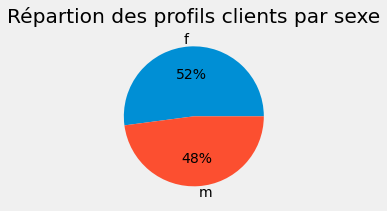

In [27]:
##############################################################
# Répartition des clients par sexe

print(ca.groupby(['sex'])
.agg({'client_id': "nunique", 'price': 'mean'})[['client_id', 'price']]
.assign(Part_de_CA = lambda x: 100*x['price']/x['price'].sum())
.rename(columns={'client_id': 'Nb de clients', 'price': 'Prix moyen'}))

ca.groupby(['sex'])['client_id'].nunique()\
.plot.pie(legend=False, subplots=True,figsize=(8, 3),autopct='%1.0f%%');
plt.ylabel('')
plt.title('Répartion des profils clients par sexe');

        % clients       % CA
decade                      
1980    19.923238  25.179723
1990    18.271691  20.564901
1970    19.574320  20.138042
1960    14.782508  12.434628
2000    11.491044  11.078964
1950    10.514073   7.069871
1940     4.035822   2.667556
1930     1.372412   0.838599
1920     0.034892   0.027716


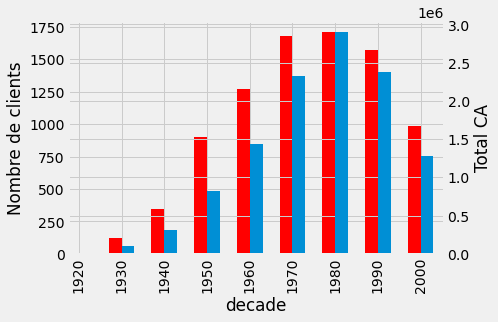

In [28]:
##############################################################
# Répartition des clients par tranche d'âge

ca['decade'] = 10 * (ca['birth'] // 10)

print(ca.groupby(['decade'])\
.agg({'client_id': "nunique", 'price': "sum"})[['client_id', 'price']]\
.apply(lambda x: 100*x/x.sum())\
.sort_values(by='price', ascending=False)\
.rename(columns={'client_id': '% clients', 'price': '% CA'}))

## Graphique 
## https://stackoverflow.com/questions/24183101/pandas-bar-plot-with-two-bars-and-two-y-axis

fig = plt.figure()

ax = fig.add_subplot(111)
ax2 = ax.twinx()

width = 0.3

ca.groupby(['decade'])['client_id'].nunique().plot(kind='bar', color='r', ax=ax, width=width, position=1)
ca.groupby(['decade'])['price'].sum().plot(kind='bar', ax=ax2, width=width, position=0)

ax.set_ylabel('Nombre de clients')
ax2.set_ylabel('Total CA')

plt.show()

## Partie 2 - Analyse ciblée sur les clients<a class="anchor" id="P2"></a>


### 2.1 Lien entre le genre d’un client et les catégories des livres achetés<a class="anchor" id="P21"></a>

In [29]:
##############################################################
# Répartition des clients par catégories de livres

cont_table = ca.groupby(['sex', 'categ'])\
.agg({'id_prod': "count"})[['id_prod']]\
.unstack()

##############################################################
# Test du Khi2 sur la répartition des clients par catégories de livres
# Hypothèses
# H0 : La proportion de catégorie de livres achetés est indépendante du sexe
# H1 : La proportion de catégorie de livres achetés est associée au sexe

import scipy.stats as stats

stats.chi2_contingency(cont_table)

(143.4684942757229,
 7.017982881623974e-32,
 2,
 array([[197878.5927225 , 112423.73301496,  17604.67426253],
        [199032.4072775 , 113079.26698504,  17707.32573747]]))

La p-value ici est inférieur à 0.05 donc H0 peut être rejetée. 
Il y a un lien entre le genre d'un client et les catégories de livres achetés

### 2.2 Lien entre l’âge des clients et le montant total des achats, la fréquence d’achat, la taille du panier moyen et les catégories des livres achetés<a class="anchor" id="P22"></a>

Lien entre l'âge et le montant des achats (0.039189387620621456, 0.0002782831921474799)


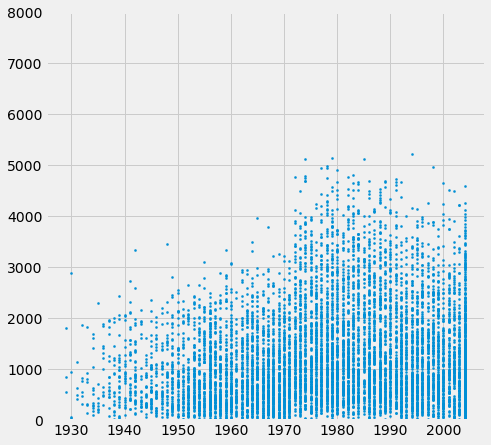

Lien entre l'âge et la quantité d'achat (fréquence d'achat) (-0.007274862642895672, 0.5000091179659889)


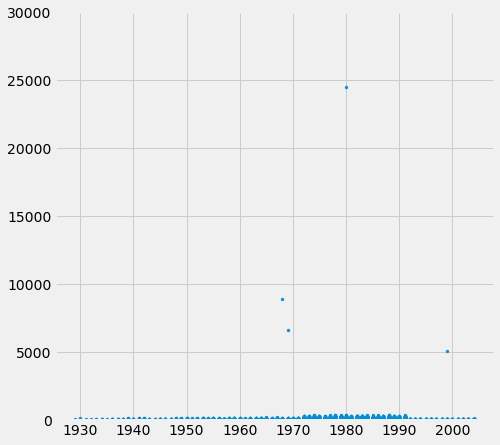

Lien entre l'âge et la quantité d'achat (sans outliers) (-0.03286427358882094, 0.002311193635707138)


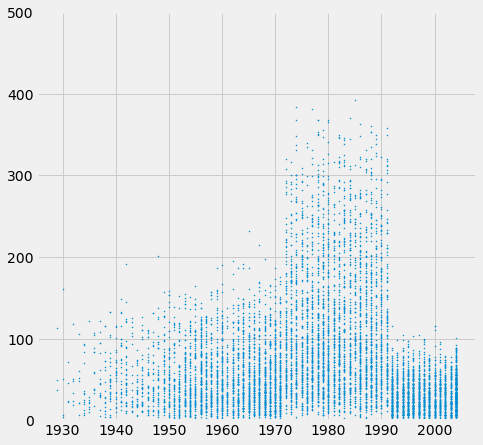

Lien entre l'âge et la taille du panier moyen (0.5090470800051581, 0.0)


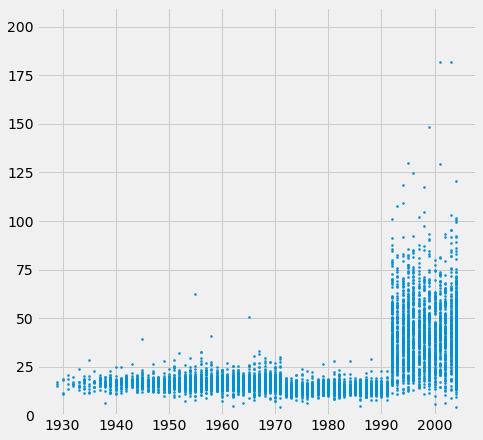

Lien entre l'âge et la catégorie de livres achetés


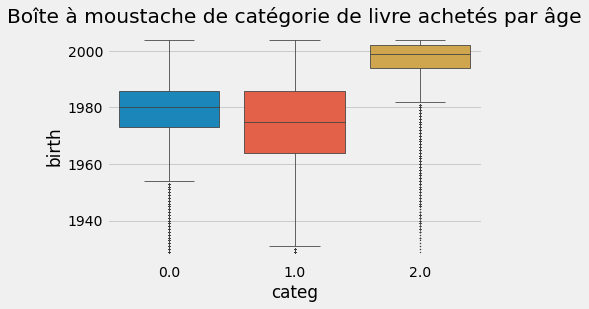

Visualiser si les données suivent une loi normale


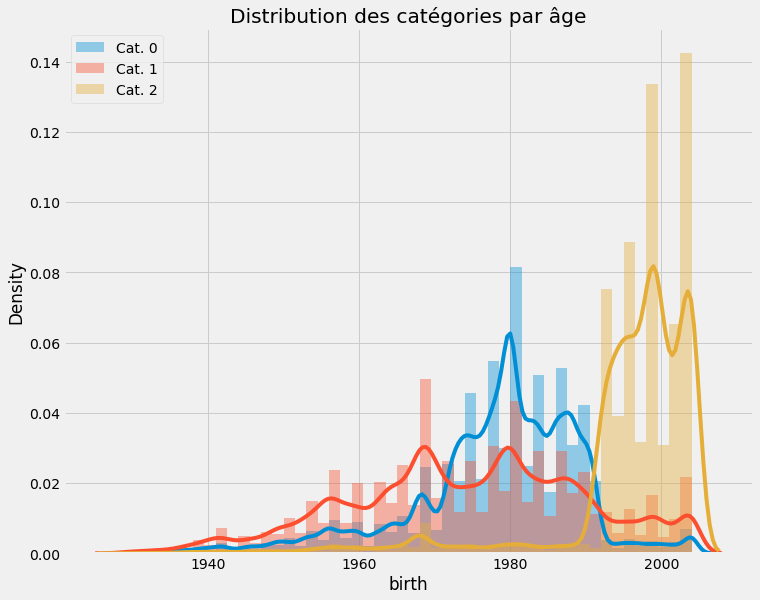

Test KS, Catégorie 0: KstestResult(statistic=1.0, pvalue=0.0)
Test KS, Catégorie 1: KstestResult(statistic=1.0, pvalue=0.0)
Test KS, Catégorie 2: KstestResult(statistic=1.0, pvalue=0.0)
Résultat du test de Kruskal Wallis:  KruskalResult(statistic=76847.37267274865, pvalue=0.0)


In [30]:
##############################################################
# Ajouter les éléments tels que le CA, panier moyen, et fréquence d'achat 

ca['CA'] = ca['price'].groupby(ca['client_id']).transform('sum')
ca['panier moyen'] = ca['price'].groupby(ca['client_id']).transform('mean')
ca['quantité'] = ca['price'].groupby(ca['client_id']).transform('count')


##############################################################
# Créer un DF pour avoir une ligne unique par clients

unique = ca.drop_duplicates(subset='client_id')

##############################################################
# Test de Pearson afin de voir s'il y a une corrélation entre 2 variables quantitatives

from scipy.stats import pearsonr
# la première valeur est le coefficent de corrélation, la seconde est la p-value
# si le coéfficient de corrélation tend vers 0 la corrélation est négligeable
# à l"inverse si il tend vers 1 la corrélation est fort

## Lien entre l'âge et le montant des achats
print("Lien entre l'âge et le montant des achats", pearsonr(unique['birth'], unique['CA']))
plt.figure(figsize=(7, 7))
plt.ylim(0, 8000)
plt.scatter(unique['birth'], unique['CA'], s=4)
plt.show()

## Lien entre l'âge et la quantité d'achat (fréquence d'achat)
print("Lien entre l'âge et la quantité d'achat (fréquence d'achat)", pearsonr(unique['birth'], unique['quantité']))
plt.figure(figsize=(7, 7))
plt.ylim(0, 30000)
plt.scatter(unique['birth'], unique['quantité'], s=8)
plt.show()
# On se rend compte qu'il y des outliers qui pourrait venir biaiser le test
# On enlève les outliers et relance un test

unique2 = unique[unique['quantité']<4000]
print("Lien entre l'âge et la quantité d'achat (sans outliers)", pearsonr(unique2['birth'], unique2['quantité']))
plt.figure(figsize=(7, 7))
plt.ylim(0, 500)
plt.scatter(unique2['birth'], unique2['quantité'], s=1)
plt.show()
# Utilisation possible de la méthode interquartile ou test de shapiro

## Lien entre l'âge et la taille du panier moyen
print("Lien entre l'âge et la taille du panier moyen", pearsonr(unique['birth'], unique['panier moyen']))
plt.figure(figsize=(7, 7))
plt.ylim(0, 210)
plt.scatter(unique['birth'], unique['panier moyen'], s=4)
plt.show()

##############################################################
# Lien entre l'âge et la catégorie de livres achetés

cat0 = ca[ca.categ == 0].birth
cat1 = ca[ca.categ == 1].birth
cat2 = ca[ca.categ == 2].birth

print("Lien entre l'âge et la catégorie de livres achetés")
sns.boxplot(x="categ", y="birth", data=ca, fliersize= 0.5, linewidth=0.8)
plt.title('Boîte à moustache de catégorie de livre achetés par âge')
plt.show();

# ANOVA : étudier l'impact d'une variable qualitative sur une variable quantitative
# Avant d'appliquer l'ANOVA il faut vérifier si nos données suivent une loi normale

# Visualisation si la distribution suit une la loi normale
print("Visualiser si les données suivent une loi normale")
import warnings; warnings.simplefilter('ignore')

f, ax = plt.subplots(figsize=(11,9))
sns.distplot(cat0, ax=ax, label='Cat. 0')
sns.distplot(cat1, ax=ax, label='Cat. 1')
sns.distplot(cat2, ax=ax, label='Cat. 2')
plt.title('Distribution des catégories par âge')
plt.legend()
plt.show();

# Test statistique loi normale
# https://www.statology.org/kolmogorov-smirnov-test-python/

from scipy.stats import kstest
print("Test KS, Catégorie 0:", kstest(cat0, 'norm'))
print("Test KS, Catégorie 1:", kstest(cat1, 'norm'))
print("Test KS, Catégorie 2:", kstest(cat2, 'norm'))

# H0 : la distribution de l'échantillon suit une loi normale
# H1 : la distribution de l'échantillon ne suit pas une loi normale
# La p-value étant inférieur à 0.05 nous pouvons rejeter l'hypothèse 0 
# Les échantillons ne suivent pas une distribution de loi normal


# Appliquer un test non paramétrique (car les données ne suivent pas une loi normale) 
# Test de Kruskal Wallis qui correspond au test de Mann-Whitney pour plus de deux échantillons. 
# Il permet de tester l'hypothèse selon laquelle les médianes de chacun des catégories de données sont proches.

# https://www.statology.org/kruskal-wallis-test-python/

print("Résultat du test de Kruskal Wallis: ", stats.kruskal(cat0, cat1, cat2))

# H0 : l'âge médian est équivalent à toutes les catégories
# H1 : l'âge médian n'est pas équivalent à toutes les catégories
# La p-value étant inférieur à 0.05 nous pouvons rejeter l'hypothèse 0 
# La catégorie de livres achetées est différente en fonction de l'âge

On conclue qu'il n'y a pas de lien entre l'âge et le montant ou la quantité des achats.\
Cependant on trouve une correlation entre l'âge et le panier moyen, ainsi que la catégorie des livres achetés.

### 2.3 Calculer la probabilité qu’un client achète la référence 0_525 sachant qu’il a acheté la référence 2_159<a class="anchor" id="P23"></a>

### Probabilité conditionnelle

Soit M l'évènement "le client achète la référence 0_525"\
Soit F l'évènement "le client achète la référence 2_159"\
Donc M∩F est l'évènement "le client achète la référence 0_525 et 2_159"

P(M) est la probalité que le client achète la référence 0_525\
P<sub>F</sub>(M) est la probabilité que le client achète la référence 0_525 en sachant qu'il a acheté la référence 2_159\
P(F) est la probalité que le client achète la référence 2_159\
P(M∩F) est la probilité de l'intersection de M et F, soit que le client a acheté la référence 0_525 et 2_159

P<sub>F</sub>(M) = P(M∩F) / P(F)

In [31]:
##############################################################
# Probabilité qu’un client achète la référence 0_525 sachant qu’il a acheté la référence 2_159

nb_client_unique = ca.drop_duplicates(subset=['client_id']).count()[0]

print("Nombre unique de clients =", nb_client_unique)
print("P(M) =", ca[ca['id_prod'] == '0_525']['client_id'].nunique(), "/", nb_client_unique)
print("P(F) =", ca[ca['id_prod'] == '2_159']['client_id'].nunique(), "/", nb_client_unique)

## Calcul de P(M∩F)
df2 = ca.loc[:, ['id_prod', 'client_id']]
R0_525 = df2[df2['id_prod'] == '0_525'].rename(columns={'id_prod': 'id_prod_0_525'})
R2_159 = df2[df2['id_prod'] == '2_159'].rename(columns={'id_prod': 'id_prod_2_159'})
df2 = pd.merge(R2_159, R0_525, on='client_id', how='inner').drop_duplicates()
print("P(M∩F) =", df2.count()[0], "/", nb_client_unique)

## PF(M) = P(M∩F) / P(F)
print('PF(M) = {:.2f}%'.format((459/307073)/(530/307073)*100))

Nombre unique de clients = 8598
P(M) = 450 / 8598
P(F) = 514 / 8598
P(M∩F) = 450 / 8598
PF(M) = 86.60%


La probabilité qu’un client achète la référence 0_525 sachant qu’il a acheté la référence 2_159 est plutôt élevée (86,60%).\
On peut supposer que le livre dont la référence est 0_525 est complémentaire au livre 2_159.

In [36]:
np.percentile(unique['quantité'], [75 ,25])

array([93., 26.])